# Analysis Notebook
Contains analysis of correlation matrix, silhouette scores, optimal number of clusters, and weather variance

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium 
import calendar
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from collections import Counter

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
import ast

import chart_studio
import chart_studio.plotly as py
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np

pd.options.mode.chained_assignment = None

In [28]:
species = pd.read_csv('assets/all_species_112222.csv')
species.drop(species.columns[species.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

locations = pd.read_csv('assets/locations_112222.csv')
locations.drop(locations.columns[locations.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# fixing NPSA coords
locations.loc[locations['Park Code'] == 'VIIS', 'Longitude'] = locations.loc[locations['Park Code'] == 'VIIS', 'Longitude']*-1

weather = pd.read_csv('assets/NPS_weather_trends_112222.csv')

activities = pd.read_csv('assets/activities.csv')
activities['cleaned'] = [ast.literal_eval(activities['cleaned'].iloc[i]) for i in range(len(activities))]

In [29]:
def regioncolors(counter):
    if counter['k_cluster'] == 0:
        return 'darkblue'
    elif counter['k_cluster'] == 1:
        return 'darkred'
    elif counter['k_cluster'] == 2:
        return 'blue'
    elif counter['k_cluster'] == 3:
        return 'darkgreen'
    else:
        return 'darkpurple'

In [30]:
class Cluster:
    def __init__(self, park, month, sim_or_diff):
        self.park = park
        self.month = month
        self.sim_or_diff = sim_or_diff

        self.weather_sp = []
        #self.KM = KMeans(n_clusters = 5, random_state = 42)
        self.transform_weather()
        self.get_species_df()
        self.transform_species()
        self.combine_weather_sp()

    def transform_weather(self):
        '''Clean and scale weather data'''
        park_weather = weather[['ParkName', 'Month', 'Year', 'Temp_Avg_Fahrenheit', 'Prcp_Avg_Inches']]
        avg_10_yr = park_weather.groupby(['ParkName','Month']).agg('mean').reset_index().drop(columns = 'Year')
        avg_10_yr.rename(columns = {'ParkName':'park', 'Month':'month','Temp_Avg_Fahrenheit':'temp', 'Prcp_Avg_Inches':'prcp'}, inplace = True)
        avg_10_yr['month_name'] = avg_10_yr['month'].apply(lambda x: calendar.month_abbr[x])

        avg_10_yr = avg_10_yr[avg_10_yr['month_name'] == self.month]

        clus_temp = avg_10_yr[['temp', 'prcp']]
        self.X = StandardScaler().fit_transform(clus_temp)
        self.avg_10_yr = avg_10_yr

    def get_species_df(self):
        '''Return df of parks and list of species'''
        # sort park names for future merging
        temp_merged = self.avg_10_yr.merge(locations, how = 'left', left_on = 'park', right_on = 'Park Name')
        sort_parks = temp_merged['Park Code'].tolist()
        # new df with only species that are present 
        present_sp = species[species['Occurrence'] == 'Present']
        similarity_df = present_sp[['Park Name', 'Scientific Name', 'Park Code']]
        sort_i = dict(zip(sort_parks, range(len(sort_parks))))
        similarity_df['park_code_ranked'] = similarity_df['Park Code'].map(sort_i)
        similarity_df.sort_values(by = ['park_code_ranked'], inplace = True)
        similarity_df.drop('park_code_ranked', axis = 1, inplace = True)

        # list of all park codes
        park_codes = list(similarity_df['Park Code'].unique())
        # list of all species in a park
        code_sp_list = []
        for code in park_codes:
            sp = list(similarity_df[similarity_df['Park Code'] == code]['Scientific Name'])
            #sp.append(code)
            code_sp_list.append(sp)

        # new park-species dataframe
        park_sp_df = pd.DataFrame()
        park_sp_df['park_code'] = park_codes
        park_sp_df['species_list'] = code_sp_list
        self.park_sp_df = park_sp_df

    def transform_species(self):
        '''Transform species df'''
        # 0 if species is not present, 1 if species is present
        mlb = MultiLabelBinarizer()
        vec = mlb.fit_transform(self.park_sp_df['species_list'])
        vecs = pd.DataFrame(vec, columns=mlb.classes_)

        # apply cosine_similarity fxn on df
        df_cosine = pd.DataFrame(cosine_similarity(vecs,dense_output=True))

        # pca for dimensitonality reduction
        pca = PCA(n_components = 0.85)
        transform = pca.fit_transform(df_cosine)
        self.transform = transform

    def combine_weather_sp(self):
        '''Combine weather and species vecs'''
        # concat weather and species vecs
        for i in range(len(self.park_sp_df)):
            concat = np.concatenate((self.X[i], self.transform[i]))
            self.weather_sp.append(concat)
        self.weather_sp_arr = np.array(self.weather_sp)[:62]
        return self.weather_sp_arr

    def kmeans(self):
        '''Perform K-means, return list of parks, map and silhouette score'''
        visualizer = KElbowVisualizer(KMeans(random_state = 42), k=(2,11), show = False)
        visualizer.fit(self.weather_sp_arr)
        optimal_k = visualizer.elbow_value_
        plt.close()
        KM = KMeans(n_clusters = optimal_k, random_state = 42)
        temp_labels = KM.fit_predict(self.weather_sp_arr)
        labs = np.unique(temp_labels)
        
        self.avg_10_yr['k_cluster'] = temp_labels
        temp_merged = self.avg_10_yr.merge(locations, how = 'left', left_on = 'park', right_on = 'Park Name')     
        temp_merged['color'] = temp_merged.apply(regioncolors, axis = 1)
        
        us_map = folium.Map(tiles='CartoDB positron', zoom_start=14)
    
        location_list = temp_merged[['Latitude', 'Longitude']].values.tolist()
        park_names = temp_merged['Park Name'].tolist()  
        for point in range(0, len(location_list)):
            folium.Marker(location_list[point],popup=park_names[point], icon=folium.Icon(color=temp_merged["color"][point], icon_color='white', icon='star', angle=0, prefix='fa')).add_to(us_map)
        #display(us_map)
        sil_score = silhouette_score(self.weather_sp_arr, KM.fit_predict(self.weather_sp_arr))

        user_cluster = temp_merged[temp_merged['park'] == self.park]['k_cluster'].item()
        
        if self.sim_or_diff == 'Similar':
            user_parks = temp_merged[temp_merged['k_cluster'] == user_cluster]['park'].tolist()
        elif self.sim_or_diff == 'Different':
            user_parks = temp_merged[temp_merged['k_cluster'] != user_cluster]['park'].tolist()
        return user_cluster, user_parks, sil_score, optimal_k, us_map, temp_merged

In [31]:
Cluster('Yosemite National Park', 'Jun', 'Similar').kmeans()[4]

### Pearson Correlation Matrix

In [32]:
# connect to chart studio
chart_studio.tools.set_credentials_file(username='lching', api_key = 'kXp5arxg71xNaFmcXOSq')

In [33]:
avg_10_yr = weather.groupby(['ParkName','Month']).agg('mean').reset_index().drop(columns = 'Year')
avg_10_yr.rename(columns = {'ParkName':'park', 'Month':'month','Temp_Avg_Fahrenheit':'temp', 'Prcp_Avg_Inches':'prcp'}, inplace = True)
avg_10_yr['month_name'] = avg_10_yr['month'].apply(lambda x: calendar.month_abbr[x])
avg_10_yr = avg_10_yr[avg_10_yr['month_name'] == 'Jun']
prk_weather = avg_10_yr[['park', 'month','temp','prcp']]

/var/folders/vb/bprs19k12d92r7xpmxnv1rx40000gn/T/ipykernel_73093/2639322634.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [34]:
weather_sp_array = Cluster('Yosemite National Park', 'Mar', 'Similar').combine_weather_sp()
ordered_code_name = Cluster('Yosemite National Park', 'Mar', 'Similar').kmeans()[5][['park', 'Park Code']]

corr = np.corrcoef(weather_sp_array)

names = ordered_code_name['park'].tolist()
shortened_names = []
for name in names:
    if name == 'National Park of American Samoa':
        short_name == 'American Samoa National Park'
    else:
        short_name = name.replace('National Park', '')
    shortened_names.append(short_name)

codes = ordered_code_name['Park Code'].tolist()
df_corr = pd.DataFrame(corr, index = shortened_names, columns = shortened_names)

X = np.repeat(shortened_names, len(df_corr.columns)).reshape(len(df_corr), len(df_corr))

fig = px.imshow(df_corr, labels = dict(x = 'Park 1', y = 'Park 2', color = 'Correlation'), color_continuous_scale = 'Pinkyl')
fig.update(data=[{'customdata': np.swapaxes(X, 0, 1), 
    'hovertemplate': 'Park 1: %{customdata}<br>Park 2: %{y}<br>r: %{z}<extra></extra>'}])
fig.show()

In [35]:
#py.plot(fig, filename = 'corr_heatmap', auto_open=True)

### Silhouette Score Analysis

In [36]:
avg_10_yr = weather.groupby(['ParkName','Month']).agg('mean', numeric_only = True).reset_index().drop(columns = 'Year')
avg_10_yr.rename(columns = {'ParkName':'park', 'Month':'month','Temp_Avg_Fahrenheit':'temp', 'Prcp_Avg_Inches':'prcp'}, inplace = True)
avg_10_yr['month_name'] = avg_10_yr['month'].apply(lambda x: calendar.month_abbr[x])

In [37]:
sil_scores = [Cluster('Joshua Tree National Park', month, 'Similar').kmeans()[2] for month in avg_10_yr['month_name'].unique()]
print('Mean Silhouette Score:', np.mean(sil_scores))
month_score = dict(zip(avg_10_yr['month_name'].unique(),sil_scores))

# sorted by sil score
{k: v for k, v in sorted(month_score.items(), key=lambda item: item[1], reverse= True)}

Mean Silhouette Score: 0.30314905338983317


{'Oct': 0.3414578061837295,
 'Jan': 0.3373904921452536,
 'Apr': 0.3164839609691635,
 'Nov': 0.31445045970685115,
 'Aug': 0.3142079625922196,
 'May': 0.3023829615631821,
 'Dec': 0.2956779471208909,
 'Feb': 0.29221756586415776,
 'Mar': 0.28725644916823107,
 'Sep': 0.2809880497660971,
 'Jul': 0.27996070783243093,
 'Jun': 0.2753142777657902}

Text(0.5, 1.0, 'Month vs. Silhouette Score')

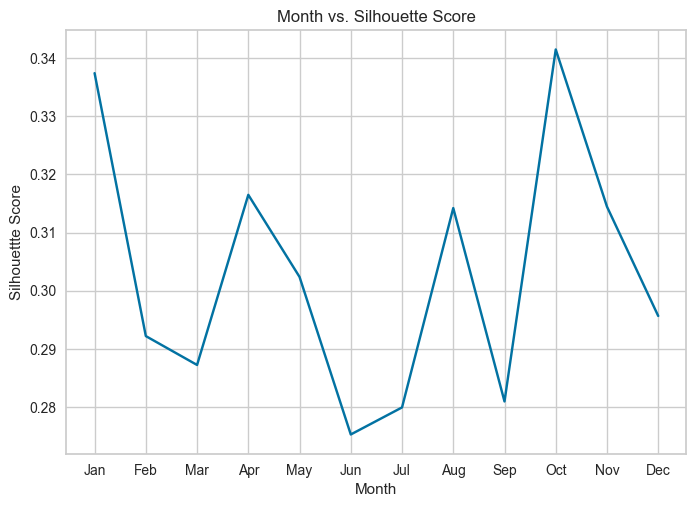

In [38]:
mn, sc = month_score.keys(), month_score.values()
plt.plot(mn, sc)
plt.xlabel('Month')
plt.ylabel('Silhouettte Score')
plt.title('Month vs. Silhouette Score')

### Optimal K Analysis

In [39]:
ks = [Cluster('Joshua Tree National Park', month, 'Similar').kmeans()[3] for month in avg_10_yr['month_name'].unique()]
month_k = dict(zip(avg_10_yr['month_name'].unique(), ks))
month_k

{'Jan': 6,
 'Feb': 5,
 'Mar': 4,
 'Apr': 5,
 'May': 5,
 'Jun': 4,
 'Jul': 4,
 'Aug': 4,
 'Sep': 5,
 'Oct': 5,
 'Nov': 5,
 'Dec': 5}

In [40]:
# analysis on January months
temp_var, prcp_var = [], []
for i in range(1,13):
    month_weather = avg_10_yr[avg_10_yr['month'] == i]
    temp_var.append(month_weather['temp'].var())
    prcp_var.append(month_weather['prcp'].var())
prcp_var

[9.435346055261762,
 8.902692227392915,
 6.845845691433105,
 5.183193179270226,
 4.379783349814913,
 6.00435597990481,
 3.916660669487044,
 4.096633923849815,
 4.071852621099947,
 5.415585278688526,
 8.808100415653094,
 10.115551654415652]

Text(0.5, 1.0, 'Month vs. Weather Variance')

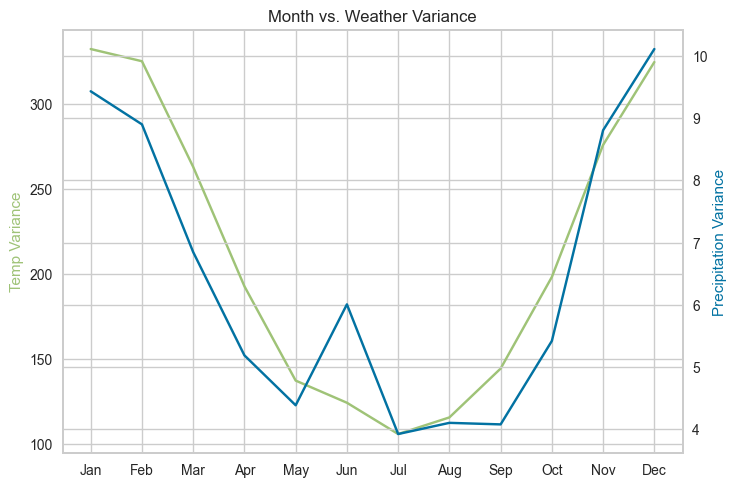

In [41]:
mn = month_k.keys()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(mn, temp_var, 'g-')
ax2.plot(mn, prcp_var, 'b-')
plt.xlabel('Month')
ax1.set_ylabel('Temp Variance', color = 'g')
ax2.set_ylabel('Precipitation Variance', color = 'b')
plt.title('Month vs. Weather Variance')

Text(0.5, 1.0, 'Month vs. Optimal K')

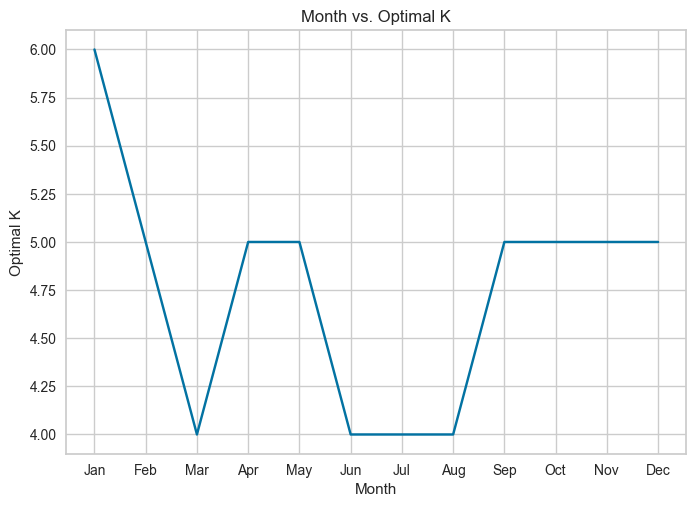

In [42]:
mn, k = month_k.keys(), month_k.values()
plt.plot(mn, k)
plt.xlabel('Month')
plt.ylabel('Optimal K')
plt.title('Month vs. Optimal K')

Generate elbow plot for final report

KElbowVisualizer(ax=<AxesSubplot: >,
                 estimator=KMeans(n_clusters=10, random_state=42), k=(2, 11))

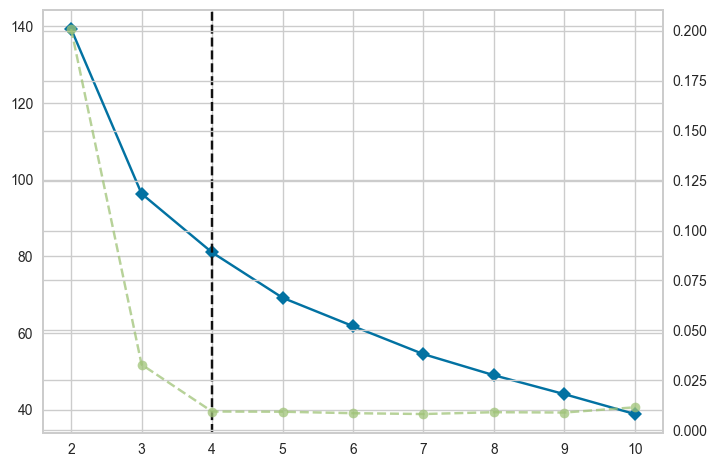

In [43]:
weather_sp_arr = Cluster('Yosemite National Park', 'Jun', 'Similar').combine_weather_sp()

visualizer = KElbowVisualizer(KMeans(random_state = 42), k=(2,11))
visualizer.fit(weather_sp_arr)
#visualizer.show(outpath="kelbow.png")